# wave-netを使ったやつ
---
わかんないのでSineで一回やってみる
とりあえずインポート

In [1]:
from keras.models import Model
from keras.layers import Input, Multiply, Conv1D, Add, Activation, Dense, Flatten
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

Using TensorFlow backend.


## wavenetの作成
---
> PixelCNNをベースにした音声波形を生成するためのディープニューラルネットワークの一つ.
> [wavenetまとめ](https://qiita.com/MasaEguchi/items/cd5f7e9735a120f27e2a)

In [2]:
def wavenetModel(input_size) :
    filter_count = 10
    output_count = 1
    def residual_block(i):
        def f(x):
            original_x = x
            tanh_out = Conv1D(filter_count, kernel_size=2,
                              strides=1, padding="causal",
                              dilation_rate=2**i, activation="tanh",
                              use_bias=False, kernel_regularizer=l2(0.))(x)
            sigm_out = Conv1D(filter_count, kernel_size=2,
                              strides=1, padding="causal",
                              dilation_rate=2**i, activation="sigmoid",
                              use_bias=False, kernel_regularizer=l2(0.))(x)
            x = Multiply()([tanh_out, sigm_out])
            res_x = Conv1D(filter_count, 1, padding="same", use_bias=False,
                           kernel_regularizer=l2(0.))(x)
            skip_x = Conv1D(filter_count, 1, padding="same", use_bias=False,
                            kernel_regularizer=l2(0.))(x)
            res_x = Add()([original_x, res_x])
            return res_x, skip_x
        return f
    input = Input(shape=(input_size, 1))
    out = input
    skip_connections = []
    out = Conv1D(filter_count, 2, dilation_rate=1, padding="causal")(out)
    for _ in range(4):
        for i in range(0, 9+1):
            out, skip_out = residual_block(i)(out)
            skip_connections.append(skip_out)
    out = Add()(skip_connections)
    out = Activation("relu")(out)
    out = Conv1D(filter_count, 1, padding="same", kernel_regularizer=l2(0.))(out)
    out = Activation("relu")(out)
    out = Conv1D(filter_count, 1, padding="same")(out)
    out = Conv1D(output_count, 1, padding="same", activation="tanh")(out)
    model = Model(input, out)
    return model

こんな感じ

## 今回やるデモ
---
sin波 to cos波 をやってみます

createSineWave() は学習の時の波
createSineWave2() は確認用の波

In [3]:
def createSineWave() :
    n = 100
    x = np.linspace(0, n, 1000*n)
    y = np.sin(x)
    return y

def createSineWave2() :
    n = 100
    x = np.linspace(0, n*10, 1000*n*10)
    y = np.sin(x)
    return y

In [4]:
# サイン波を用意
sineWave = createSineWave()
# コサイン波を用意
sineWaveFlip = sineWave*-1
# それぞれを入る形にする
SienWaveReshape = sineWave.reshape(int(sineWave.shape[0]/1000), 1000, 1)
sineWaveFlipReshape = sineWaveFlip.reshape(int(sineWaveFlip.shape[0]/1000), 1000, 1)
print(sineWave.shape)
print(SienWaveReshape.shape)
# モデルの作成＆学習
model = wavenetModel(1000)
model.compile(loss="mse", optimizer="adam")
model.fit(x=SienWaveReshape, y=sineWaveFlipReshape, epochs=100)

W0623 12:56:52.209511 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 12:56:52.222597 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 12:56:52.225440 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



(100000,)
(100, 1000, 1)


W0623 12:56:55.007190 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0623 12:56:58.350624 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0623 12:57:00.025825 4777194944 deprecation_wrapper.py:119] From /Users/suzukidaishi/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/100
100/100 [==============================] - 10s 97ms/step - loss: 0.5099
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1339
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0416
Epoch 4/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0344
Epoch 5/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0314
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0247
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0166
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0118
Epoch 9/100
100/100 [==============================] - 2s 23ms/step - loss: 0.0105
Epoch 10/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0088
Epoch 11/100
100/100 [==============================] - 2s 23ms/step - loss: 0.0076
Epoch 12/100
100/100 [==============================] - 2s 21ms/step - loss: 0.0068


100/100 [==============================] - 2s 19ms/step - loss: 8.8392e-04
Epoch 99/100
100/100 [==============================] - 2s 19ms/step - loss: 8.6460e-04
Epoch 100/100
100/100 [==============================] - 2s 19ms/step - loss: 8.6000e-04


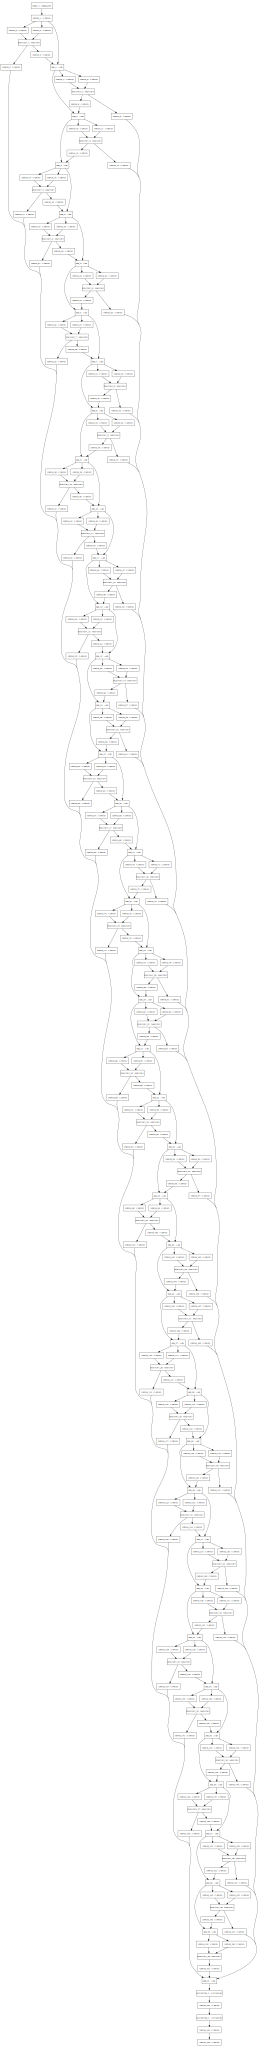

In [5]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 表示
---
青が入力波形<br>
オレンジ(見えにくいけど)が理想の出力<br>
緑が実際の出力

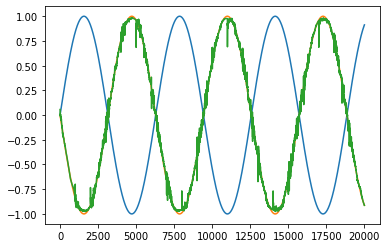

In [6]:
example = createSineWave2()
example = example.reshape(int(example.shape[0]/1000), 1000, 1)
sineWavePredict = model.predict(example).flatten()
plt.plot(createSineWave2()[:20000])
plt.plot((createSineWave2()*-1)[:20000])
plt.plot(sineWavePredict[:20000])